In [1]:
# Load Libraries used in this notebook
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# Function to Calculate difference in Date timestamps
#   date = Flight Date (when the airplane took off)
#   time1 = First time to use for calculation (i.e. DepTime)
#   time2 = Second time to use for calculatin (i.e.WheelsOff)
def calculate_date_diff(date, time1, time2):
    s1 = str(int(time1))
    s2 = str(int(time2))
    if(len(s1) < 3):
        t1 = date + dt.timedelta(minutes=time1)
    if(len(s2) < 3):
        t2 = date + dt.timedelta(minutes=time2)
    if(len(s1) == 3):
        t1 = date + dt.timedelta(hours=int(s1[0]), minutes=int(s1[-2:]))
    if(len(s2) == 3):
        t2 = date + dt.timedelta(hours=int(s2[0]), minutes=int(s2[-2:]))
    if(len(s1) > 3):
        t1 = date + dt.timedelta(hours=int(s1[:2]), minutes=int(s1[-2:]))
    if(len(s2) > 3):
        t2 = date + dt.timedelta(hours=int(s2[:2]), minutes=int(s2[-2:]))
    return (t2 - t1).total_seconds()


# Data Loading and Preprocessing

In [3]:
# Load Flight and Weather Dataset
flights_df = pd.read_csv('../data/flight_data_weather.csv')

# Convert Flight Date to a Date Timestamp
flights_df['FlightDateDT'] = pd.to_datetime(flights_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
flights_df['DepTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate the delta of DepTime and Wheels Off
flights_df['ArrTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['WheelsOn'], x['ArrTime']), axis=1)

# Reducing dimensionality of Carrier with custom grouping
value_counts = flights_df['Carrier'].value_counts()
to_remove = value_counts[value_counts <= 9000].index
flights_df['Carrier'].replace(to_remove, 'Other', inplace=True)

#  4) Calculate Employees Per Monthly Flight Count (Grand Total / Monthly Flights)
## Group flight dataset by Tail_Number
flightCount_df = pd.DataFrame(flights_df.groupby(['Carrier', 'Year', 'Month'])['Carrier'].count())
flightCount_df.rename(columns={'Carrier': 'MonthlyFlights'}, inplace=True)
flightCount_df = flightCount_df.reset_index()

## Merge Monthly flight count and calculate EmpPerMF
flights_df = pd.merge(flights_df, flightCount_df, how='left', left_on=['Carrier', 'Year', 'Month'], right_on=['Carrier', 'Year', 'Month'])
flights_df['EmpPerMF'] = flights_df['Grand Total'] / flights_df['MonthlyFlights']

# Rename ArrDel15 to Delayed - This is the column being predicted
flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

flights_df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,...,Dest_Windspeed,Dest_Precip,dest_ianaTimeZone,origin_ianaTimeZone,Aircraft_Daily_Flight_Count,FlightDateDT,DepTarmacTime,ArrTarmacTime,MonthlyFlights,EmpPerMF
0,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N407AN,664.0,KOA,...,0.0,0.0,America/Phoenix,America/Los_Angeles,1,2020-01-01,900.0,360.0,1245,86.306827
1,2020.0,1.0,1.0,1.0,3.0,2020-01-01,9E,N297PQ,5270.0,LFT,...,5.0,0.0,America/New_York,America/Chicago,1,2020-01-01,900.0,420.0,337,14.373887
2,2020.0,1.0,1.0,1.0,3.0,2020-01-01,WN,N963WN,1395.0,CMH,...,7.0,0.0,America/Chicago,America/New_York,1,2020-01-01,540.0,300.0,1542,40.347601
3,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N891NN,137.0,TUS,...,8.0,0.0,America/Chicago,America/Phoenix,1,2020-01-01,1200.0,840.0,1245,86.306827
4,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N807AW,2189.0,SAT,...,12.0,0.0,America/Chicago,America/Chicago,1,2020-01-01,660.0,960.0,1245,86.306827


In [4]:
# Output Information about the Dataframe
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343120 entries, 0 to 343119
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Year                             343120 non-null  float64       
 1   Quarter                          343120 non-null  float64       
 2   Month                            343120 non-null  float64       
 3   DayofMonth                       343120 non-null  float64       
 4   DayOfWeek                        343120 non-null  float64       
 5   FlightDate                       343120 non-null  object        
 6   Reporting_Airline                343120 non-null  object        
 7   Tail_Number                      343120 non-null  object        
 8   Flight_Number_Reporting_Airline  343120 non-null  float64       
 9   Origin                           343120 non-null  object        
 10  Dest                             343120 non-

# Model Run

In [5]:
# Columns to use as Features
features = ['DepDelay', 'Month', 'DayOfWeek', 'AirTime', 'Distance', 'DepTarmacTime', 'Origin_Windspeed','Dest_Windspeed', 'Origin_Precip', 'Dest_Precip', 'Aircraft_Daily_Flight_Count']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_binom_model.summary())

#use model to predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

#print AUC score
print('(AUC) GLM Logistic Regression: %.4f' % auc)

# Delayed = .9081
# DepTarmacTime = .9042
# 'DepDelay', 'DayOfWeek', 'DayofMonth', 'AirTime', 'Distance' = .9226
# 'DepDelay', 'DayOfWeek', 'DayofMonth', 'AirTime', 'Distance', 'DepTarmacTime' = .925
# 'DepDelay', 'DayOfWeek', 'DayofMonth', 'AirTime', 'Distance', 'DepTarmacTime', 'Origin_Windspeed','Dest_Windspeed', 'Origin_Precip', 'Dest_Precip' = .928
#  ['DepDelay', 'DayOfWeek', 'DayofMonth', 'AirTime', 'Distance', 'DepTarmacTime', 'Origin_Windspeed','Dest_Windspeed', 'Origin_Precip', 'Dest_Precip', 'Aircraft_Daily_Flight_Count'] = .936


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Delayed   No. Observations:               257340
Model:                            GLM   Df Residuals:                   257329
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78609.
Date:                Fri, 24 Nov 2023   Deviance:                   1.5722e+05
Time:                        17:02:17   Pearson chi2:                 1.05e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5395
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
DepDelay          

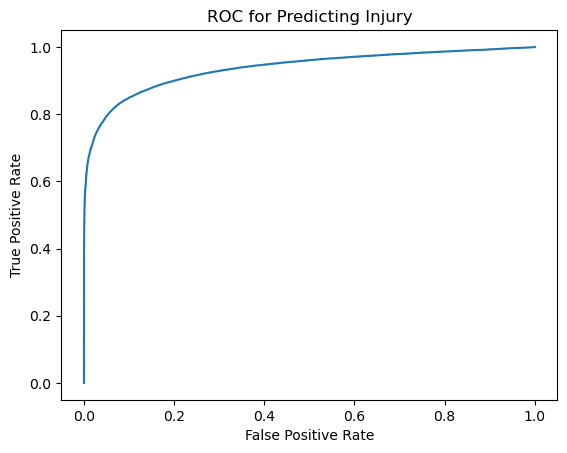

In [6]:
# define metrics
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict)

# create ROC curve
plt.plot(fpr, tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC for Predicting Injury")
plt.show()

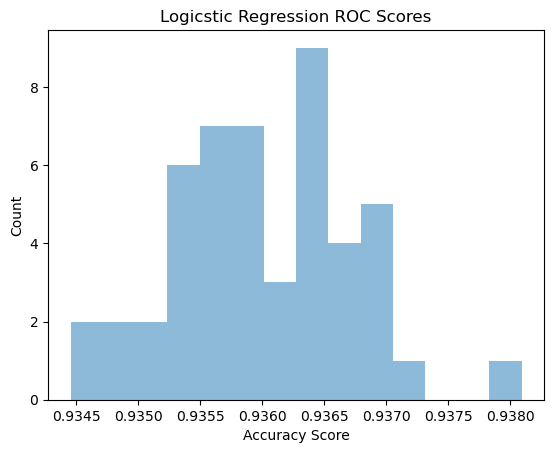

In [7]:
roc_scores = []

# Loop through model prediction 10 times
for _ in range(0,49):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

    glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
    y_predict = glm_binom_model.predict(x_test)

    #calculate AUC of model
    auc = roc_auc_score(y_test, y_predict)
    roc_scores.append(auc)


plt.hist(roc_scores, bins=14, alpha=.5)

# Pretty up the graph with labels
plt.xlabel('Accuracy Score')
plt.ylabel('Count')
plt.title('Logicstic Regression ROC Scores')
plt.show() 